In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr

from numpy import loadtxt
from numpy import sort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from matplotlib import pyplot

In [2]:
#pip install scikit_optimize

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv('test/testdata/testdata.csv')
data

,id,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,chol,smoke,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,proto,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,rldv5,rldv5e,ca,restckm,exerckm,restef,restwm,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,num
0,1,63,1,-9,-9,-9,-27,1,145,1,233,-9,50,20,1,0,1,2,2,3,1981,0,0,0,0,0,1,10.5,6.0,13.0,150,60,190,90,145,85,0,0,2.3,3,-9,-9,0,-9,-9,-9,-9,-9,-9,6,-9,-9,-9,2,16,1981,0
1,2,67,1,-9,-9,-9,-27,4,160,1,286,-9,40,40,0,0,1,2,3,5,1981,0,1,0,0,0,1,9.5,6.0,13.0,108,64,160,90,160,90,1,0,1.5,2,-9,-9,3,-9,-9,-9,-9,-9,-9,3,-9,-9,-9,2,5,1981,2
2,3,67,1,-9,-9,-9,-27,4,120,1,229,-9,20,35,0,0,1,2,2,19,1981,0,1,0,0,0,1,8.5,6.0,10.0,129,78,140,80,120,80,1,0,2.6,2,-9,-9,2,-9,-9,-9,-9,-9,-9,7,-9,-9,-9,2,20,1981,1
3,4,37,1,-9,-9,-9,-27,3,130,0,250,-9,0,0,0,0,1,0,2,13,1981,0,1,0,0,0,1,13.0,13.0,17.0,187,84,195,68,130,78,0,0,3.5,3,-9,-9,0,-9,-9,-9,-9,-9,-9,3,-9,-9,-9,2,4,1981,0
4,6,41,0,-9,-9,-9,-27,2,130,1,204,-9,0,0,0,0,1,2,2,7,1981,0,0,0,0,0,1,7.0,-9.0,9.0,172,71,160,74,130,86,0,0,1.4,1,-9,-9,0,-9,-9,-9,-9,-9,-9,3,-9,-9,-9,2,18,1981,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,315,45,1,-9,-9,-9,-27,1,110,1,264,-9,0,0,0,1,1,0,9,11,1984,1,0,0,0,0,1,12.0,12.0,13.0,132,64,160,70,110,80,0,0,1.2,2,-9,-9,0,-9,-9,-9,-9,-9,-9,7,-9,-9,-9,9,12,1984,1
299,316,68,1,-9,-9,-9,-27,4,144,0,193,-9,40,25,1,0,1,0,9,11,1984,0,0,1,0,1,1,6.7,6.0,7.0,141,54,188,74,144,76,0,0,3.4,2,-9,-9,2,-9,-9,-9,-9,-9,-9,7,-9,-9,-9,9,12,1984,2
300,317,57,1,-9,-9,-9,-27,4,130,0,131,-9,50,15,0,0,0,0,9,5,1984,0,0,0,0,0,1,8.0,6.0,9.0,115,62,170,94,130,88,1,0,1.2,2,-9,-9,1,-9,-9,-9,-9,-9,-9,7,-9,-9,-9,9,6,1984,3
301,318,57,0,-9,-9,-9,-27,2,130,1,236,-9,0,0,0,0,0,2,9,4,1984,0,0,0,1,1,1,7.5,-9.0,8.0,174,94,180,86,130,88,0,0,0.0,2,-9,-9,1,-9,-9,-9,-9,-9,-9,3,-9,-9,-9,9,6,1984,1


In [5]:
# Removing unhelpful variables (e.g. all values coded identically)

data['pncaden'].value_counts()

-27    303
Name: pncaden, dtype: int64

In [6]:
identical_values = []
for i in data.columns:
    if len(data[i].value_counts()) == 1: ## find the columns which has only on value
        identical_values.append(i)
identical_values

['painloc',
 'painexer',
 'relrest',
 'pncaden',
 'smoke',
 'proto',
 'rldv5',
 'rldv5e',
 'restckm',
 'exerckm',
 'restef',
 'restwm',
 'exeref',
 'exerwm',
 'thalsev',
 'thalpul',
 'earlobe']

In [7]:
data.drop(identical_values, axis=1, inplace = True) ## drop the meaningless variables

In [8]:
data

,id,age,sex,cp,trestbps,htn,chol,cigs,years,fbs,dm,famhist,restecg,ekgmo,ekgday,ekgyr,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,slope,ca,thal,cmo,cday,cyr,num
0,1,63,1,1,145,1,233,50,20,1,0,1,2,2,3,1981,0,0,0,0,0,10.5,6.0,13.0,150,60,190,90,145,85,0,0,2.3,3,0,6,2,16,1981,0
1,2,67,1,4,160,1,286,40,40,0,0,1,2,3,5,1981,0,1,0,0,0,9.5,6.0,13.0,108,64,160,90,160,90,1,0,1.5,2,3,3,2,5,1981,2
2,3,67,1,4,120,1,229,20,35,0,0,1,2,2,19,1981,0,1,0,0,0,8.5,6.0,10.0,129,78,140,80,120,80,1,0,2.6,2,2,7,2,20,1981,1
3,4,37,1,3,130,0,250,0,0,0,0,1,0,2,13,1981,0,1,0,0,0,13.0,13.0,17.0,187,84,195,68,130,78,0,0,3.5,3,0,3,2,4,1981,0
4,6,41,0,2,130,1,204,0,0,0,0,1,2,2,7,1981,0,0,0,0,0,7.0,-9.0,9.0,172,71,160,74,130,86,0,0,1.4,1,0,3,2,18,1981,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,315,45,1,1,110,1,264,0,0,0,1,1,0,9,11,1984,1,0,0,0,0,12.0,12.0,13.0,132,64,160,70,110,80,0,0,1.2,2,0,7,9,12,1984,1
299,316,68,1,4,144,0,193,40,25,1,0,1,0,9,11,1984,0,0,1,0,1,6.7,6.0,7.0,141,54,188,74,144,76,0,0,3.4,2,2,7,9,12,1984,2
300,317,57,1,4,130,0,131,50,15,0,0,0,0,9,5,1984,0,0,0,0,0,8.0,6.0,9.0,115,62,170,94,130,88,1,0,1.2,2,1,7,9,6,1984,3
301,318,57,0,2,130,1,236,0,0,0,0,0,2,9,4,1984,0,0,0,1,1,7.5,-9.0,8.0,174,94,180,86,130,88,0,0,0.0,2,1,3,9,6,1984,1


In [9]:
# check the data types in the table

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 40 columns):
id          303 non-null int64
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
htn         303 non-null int64
chol        303 non-null int64
cigs        303 non-null int64
years       303 non-null int64
fbs         303 non-null int64
dm          303 non-null int64
famhist     303 non-null int64
restecg     303 non-null int64
ekgmo       303 non-null int64
ekgday      303 non-null int64
ekgyr       303 non-null int64
dig         303 non-null int64
prop        303 non-null int64
nitr        303 non-null int64
pro         303 non-null int64
diuretic    303 non-null int64
thaldur     303 non-null float64
thaltime    303 non-null float64
met         303 non-null float64
thalach     303 non-null int64
thalrest    303 non-null int64
tpeakbps    303 non-null int64
tpeakbpd    303 non-null int64
dummy       303 non-n

In [10]:
# One-hot encode the categorical variables (the variables only include 0 and -1 don't need to be encoded)

new_df = pd.get_dummies(data, columns=["cp", "restecg","ekgmo","ekgday","ekgyr","slope","thal","cmo","cday","cyr"], prefix=["cp", "restecg","ekgmo","ekgday","ekgyr","slope","thal","cmo","cday","cyr"])
new_df

,id,age,sex,trestbps,htn,chol,cigs,years,fbs,dm,famhist,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,ca,num,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,ekgmo_1,ekgmo_2,ekgmo_3,ekgmo_4,ekgmo_5,ekgmo_6,ekgmo_7,ekgmo_8,ekgmo_9,ekgmo_10,ekgmo_11,ekgmo_12,ekgday_1,ekgday_2,ekgday_3,ekgday_4,ekgday_5,ekgday_6,ekgday_7,ekgday_8,ekgday_9,ekgday_10,ekgday_11,ekgday_12,ekgday_13,ekgday_14,ekgday_15,ekgday_16,ekgday_17,ekgday_18,ekgday_19,ekgday_20,ekgday_21,ekgday_22,ekgday_23,ekgday_24,ekgday_25,ekgday_26,ekgday_27,ekgday_28,ekgday_29,ekgday_30,ekgday_31,ekgyr_1981,ekgyr_1982,ekgyr_1983,ekgyr_1984,slope_1,slope_2,slope_3,thal_-9,thal_3,thal_6,thal_7,cmo_-9,cmo_1,cmo_2,cmo_3,cmo_4,cmo_5,cmo_6,cmo_7,cmo_8,cmo_9,cmo_10,cmo_11,cmo_12,cday_-9,cday_1,cday_2,cday_3,cday_4,cday_5,cday_6,cday_7,cday_8,cday_9,cday_10,cday_11,cday_12,cday_13,cday_14,cday_15,cday_16,cday_17,cday_18,cday_19,cday_20,cday_21,cday_22,cday_23,cday_24,cday_25,cday_26,cday_27,cday_28,cday_29,cday_30,cday_31,cyr_-9,cyr_1981,cyr_1982,cyr_1983,cyr_1984
0,1,63,1,145,1,233,50,20,1,0,1,0,0,0,0,0,10.5,6.0,13.0,150,60,190,90,145,85,0,0,2.3,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2,67,1,160,1,286,40,40,0,0,1,0,1,0,0,0,9.5,6.0,13.0,108,64,160,90,160,90,1,0,1.5,3,2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3,67,1,120,1,229,20,35,0,0,1,0,1,0,0,0,8.5,6.0,10.0,129,78,140,80,120,80,1,0,2.6,2,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4,37,1,130,0,250,0,0,0,0,1,0,1,0,0,0,13.0,13.0,17.0,187,84,195,68,130,78,0,0,3.5,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,6,41,0,130,1,204,0,0,0,0,1,0,0,0,0,0,7.0,-9.0,9.0,172,71,160,74,130,86,0,0,1.4,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,315,45,1,110,1,264,0,0,0,1,1,1,0,0,0,0,12.0,12.0,13.0,132,64,160,70,110,80,0,0,1.2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
299,316,68,1,144,0,193,40,25,1,0,1,0,0,1,0,1,6.7,6.0,7.0,141,54,188,74,144,76,0,0,3.4,2,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
300,317,57,1,130,0,131,50,15,0,0,0,0,0,0,0,0,8.0,6.0,9.0,115,62,170,94,130,88,1,0,1.2,1,3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [11]:
# Convert the response variable (num) into a binary variable

new_num = (data["num"] > 0).astype('int')
new_df.drop(['num'], axis=1, inplace = True)
new_df['num'] = new_num
new_df

,id,age,sex,trestbps,htn,chol,cigs,years,fbs,dm,famhist,dig,prop,nitr,pro,diuretic,thaldur,thaltime,met,thalach,thalrest,tpeakbps,tpeakbpd,dummy,trestbpd,exang,xhypo,oldpeak,ca,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,ekgmo_1,ekgmo_2,ekgmo_3,ekgmo_4,ekgmo_5,ekgmo_6,ekgmo_7,ekgmo_8,ekgmo_9,ekgmo_10,ekgmo_11,ekgmo_12,ekgday_1,ekgday_2,ekgday_3,ekgday_4,ekgday_5,ekgday_6,ekgday_7,ekgday_8,ekgday_9,ekgday_10,ekgday_11,ekgday_12,ekgday_13,ekgday_14,ekgday_15,ekgday_16,ekgday_17,ekgday_18,ekgday_19,ekgday_20,ekgday_21,ekgday_22,ekgday_23,ekgday_24,ekgday_25,ekgday_26,ekgday_27,ekgday_28,ekgday_29,ekgday_30,ekgday_31,ekgyr_1981,ekgyr_1982,ekgyr_1983,ekgyr_1984,slope_1,slope_2,slope_3,thal_-9,thal_3,thal_6,thal_7,cmo_-9,cmo_1,cmo_2,cmo_3,cmo_4,cmo_5,cmo_6,cmo_7,cmo_8,cmo_9,cmo_10,cmo_11,cmo_12,cday_-9,cday_1,cday_2,cday_3,cday_4,cday_5,cday_6,cday_7,cday_8,cday_9,cday_10,cday_11,cday_12,cday_13,cday_14,cday_15,cday_16,cday_17,cday_18,cday_19,cday_20,cday_21,cday_22,cday_23,cday_24,cday_25,cday_26,cday_27,cday_28,cday_29,cday_30,cday_31,cyr_-9,cyr_1981,cyr_1982,cyr_1983,cyr_1984,num
0,1,63,1,145,1,233,50,20,1,0,1,0,0,0,0,0,10.5,6.0,13.0,150,60,190,90,145,85,0,0,2.3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,67,1,160,1,286,40,40,0,0,1,0,1,0,0,0,9.5,6.0,13.0,108,64,160,90,160,90,1,0,1.5,3,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,3,67,1,120,1,229,20,35,0,0,1,0,1,0,0,0,8.5,6.0,10.0,129,78,140,80,120,80,1,0,2.6,2,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,4,37,1,130,0,250,0,0,0,0,1,0,1,0,0,0,13.0,13.0,17.0,187,84,195,68,130,78,0,0,3.5,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,6,41,0,130,1,204,0,0,0,0,1,0,0,0,0,0,7.0,-9.0,9.0,172,71,160,74,130,86,0,0,1.4,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,315,45,1,110,1,264,0,0,0,1,1,1,0,0,0,0,12.0,12.0,13.0,132,64,160,70,110,80,0,0,1.2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
299,316,68,1,144,0,193,40,25,1,0,1,0,0,1,0,1,6.7,6.0,7.0,141,54,188,74,144,76,0,0,3.4,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
300,317,57,1,130,0,131,50,15,0,0,0,0,0,0,0,0,8.0,6.0,9.0,115,62,170,94,130,88,1,0,1.2,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [12]:
# Create a pipeline for determining if there are missing values
# Return a list containing the column names where there are missing values

missing_variables = []
for i in new_df.columns:
    if (-9 in set(new_df[i])):
        missing_variables.append(i)
missing_variables

['cigs', 'years', 'dig', 'prop', 'nitr', 'pro', 'diuretic', 'thaltime', 'ca']

In [13]:
# Use pipeline to look at any correlations / obvious relationships between pairwise features
# for-loop through all the features

correlation_list = []
for i in new_df.columns:
    for j in new_df.columns:
        correlation_list.append((pearsonr(new_df[i],new_df[j])[0],i,j))
correlation_list

[(1.0, 'id', 'id'),
 (-0.002445026759849027, 'id', 'age'),
 (-0.0715331962159299, 'id', 'sex'),
 (-0.021556458567591683, 'id', 'trestbps'),
 (-0.06504586753487945, 'id', 'htn'),
 (-0.09099302734205651, 'id', 'chol'),
 (-0.11014762602684926, 'id', 'cigs'),
 (-0.08511027010883992, 'id', 'years'),
 (-0.03798026395141428, 'id', 'fbs'),
 (0.09140224864714988, 'id', 'dm'),
 (0.03640061913543305, 'id', 'famhist'),
 (0.0024646733130875946, 'id', 'dig'),
 (-0.06247486535807054, 'id', 'prop'),
 (0.0074090101339155875, 'id', 'nitr'),
 (0.07452341492505457, 'id', 'pro'),
 (0.016718578917097486, 'id', 'diuretic'),
 (-0.034101595382114255, 'id', 'thaldur'),
 (-0.16377211721225615, 'id', 'thaltime'),
 (-0.14366435224786067, 'id', 'met'),
 (-0.10589494689118045, 'id', 'thalach'),
 (-0.02500745255975769, 'id', 'thalrest'),
 (-0.030183305699314933, 'id', 'tpeakbps'),
 (-0.1432402528610799, 'id', 'tpeakbpd'),
 (-0.021556458567591683, 'id', 'dummy'),
 (-0.13952227181812732, 'id', 'trestbpd'),
 (0.00130171

In [14]:
# Converting the resulting dataframe to an array

df_array = new_df.values
df_array

array([[  1.,  63.,   1., ...,   0.,   0.,   0.],
       [  2.,  67.,   1., ...,   0.,   0.,   1.],
       [  3.,  67.,   1., ...,   0.,   0.,   1.],
       ...,
       [317.,  57.,   1., ...,   0.,   1.,   1.],
       [318.,  57.,   0., ...,   0.,   1.,   1.],
       [319.,  38.,   1., ...,   0.,   0.,   0.]])

In [15]:
# Build an XGBoost classifer using the cleaned heart data

In [16]:
# split data into X and y

X = df_array[:,0:140]
Y = df_array[:,140]

In [17]:
# split data into train and test sets

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [18]:
# fit model no training data

model = xgb.XGBClassifier()
model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 0)

[23:37:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [19]:
# make predictions for test data

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [20]:
# evaluate predictions

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity: %.2f%%" % (sensitivity * 100.0))
print("Specificity: %.2f%%" % (specificity * 100.0))

f1 = f1_score(y_test, predictions)
print("F1: %.2f%%" % (f1 * 100.0))

auc = roc_auc_score(y_test, predictions)
print("AUC: %.2f%%" % (auc * 100.0))

Accuracy: 80.00%
Sensitivity: 72.22%
Specificity: 89.13%
F1: 79.59%
AUC: 80.68%


In [21]:
# tune the nine hyperparameters the authors mention using a Bayesian Optimization approach

bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'auc',
        use_label_encoder = False
    ),
    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'max_depth': Integer(0, 10),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(0.01, 1000.0, 'log-uniform'),
        'reg_alpha': Real(0.01, 100.0, 'log-uniform'),
        'gamma': Real(0.001, 5.0, 'log-uniform'),
        'n_estimators': Integer(50, 1000),
    },    
    scoring = 'roc_auc',
    n_jobs = 3,
    n_iter = 10,
    verbose = 0,
    random_state = 123
)

In [22]:
%%time

result = bayes_cv_tuner.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will 

CPU times: user 4.54 s, sys: 223 ms, total: 4.76 s
Wall time: 6.44 s


In [23]:
result.optimizer_results_[0]

          fun: -0.8827568473653067
    func_vals: array([-0.83728284, -0.5       , -0.86749819, -0.87238834, -0.88275685,
       -0.5       , -0.5       , -0.68905294, -0.81462737, -0.5       ])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=843828734)]
 random_state: RandomState(MT19937) at 0x7FF5EE8C37C0
        space: Space([Real(low=0.01, high=1.0, prior='uniform', transform='normalize'),
       Real(low=0.001, high=5.0, prior='log-uniform', transform='normalize'),
       Real(low=0.01, high=1.0, prior='log-uniform', transform='normalize'),
       Integer(low=0, high=10, prior='uniform', transform='normalize'),
       Integer(low=0, high=5, prior='uniform', tra

In [24]:
best_params = result.best_params_
best_params

OrderedDict([('colsample_bytree', 0.33755907021465986),
             ('gamma', 0.0475057761762948),
             ('learning_rate', 0.014221987123000417),
             ('max_depth', 7),
             ('min_child_weight', 2),
             ('n_estimators', 485),
             ('reg_alpha', 0.09937988268410759),
             ('reg_lambda', 3.6079084572422384),
             ('subsample', 0.23543704684289332)])

In [25]:
model_tuned = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', use_label_encoder = False,
                                **best_params)
model_tuned.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.33755907021465986,
              enable_categorical=False, eval_metric='auc',
              gamma=0.0475057761762948, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.014221987123000417,
              max_delta_step=0, max_depth=7, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=485, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0.09937988268410759,
              reg_lambda=3.6079084572422384, scale_pos_weight=1,
              subsample=0.23543704684289332, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [26]:
y_pred_new = model_tuned.predict(X_test)
predictions_new = [round(value) for value in y_pred_new]

accuracy_new = accuracy_score(y_test, predictions_new)
print("Accuracy: %.2f%%" % (accuracy_new * 100.0))

tn_new, fp_new, fn_new, tp_new = confusion_matrix(y_test, predictions_new).ravel()
sensitivity_new = tp_new / (tp_new + fn_new)
specificity_new = tn_new / (tn_new + fp_new)
print("Sensitivity: %.2f%%" % (sensitivity_new * 100.0))
print("Specificity: %.2f%%" % (specificity_new * 100.0))

f1_new = f1_score(y_test, predictions_new)
print("F1: %.2f%%" % (f1_new * 100.0))

auc_new = roc_auc_score(y_test, predictions_new)
print("AUC: %.2f%%" % (auc_new * 100.0))

Accuracy: 85.00%
Sensitivity: 75.93%
Specificity: 95.65%
F1: 84.54%
AUC: 85.79%


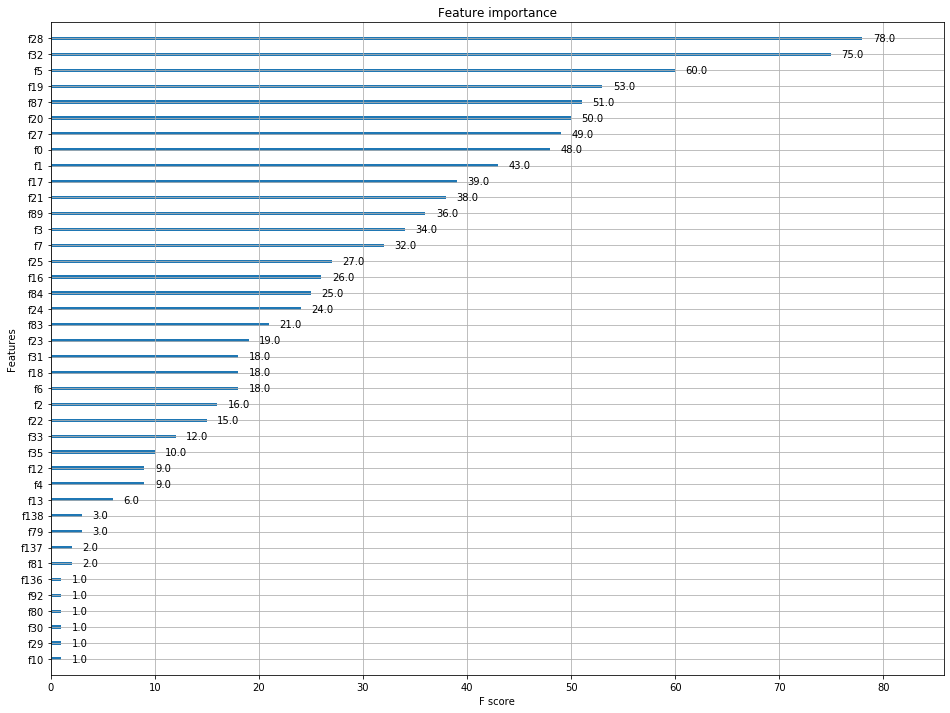

In [27]:
# Extract and plot feature importance values for your model

pyplot.rcParams["figure.figsize"] = (16,12)
xgb.plot_importance(model_tuned)
pyplot.show()

In [28]:
# Iterate through different importance threshold values to select a less complex model that maximizes accuracy

thresholds = sort(model_tuned.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_tuned, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', use_label_encoder = False,
                                        **best_params)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions_select = selection_model.predict(select_X_test)
    accuracy_select = accuracy_score(y_test, predictions_select)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy_select*100.0))

Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000, n=140, Accuracy: 85.00%
Thresh=0.000

In [29]:
# Final model

selection = SelectFromModel(model_tuned, threshold=0.036, prefit=True)
select_X_train = selection.transform(X_train)
selection_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', use_label_encoder = False,
                                    **best_params)
selection_model.fit(select_X_train, y_train)
select_X_test = selection.transform(X_test)
predictions_select = selection_model.predict(select_X_test)
accuracy_select = accuracy_score(y_test, predictions_select)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.036, select_X_train.shape[1], accuracy_select*100.0))

Thresh=0.036, n=9, Accuracy: 85.00%


Reference:
<br> Brownlee, Jason. “Data Preparation for Gradient Boosting with XGBoost in Python.” Machine Learning Mastery, 27 Aug. 2020, https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/. 
<br> Brownlee, Jason. “How to Develop Your First XGBoost Model in Python.” Machine Learning Mastery, 18 Jan. 2021, https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/. 
<br> Brownlee, Jason. “Feature Importance and Feature Selection with XGBoost in Python.” Machine Learning Mastery, 27 Aug. 2020, https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/. 
<br> Nanomathias. “Bayesian Optimization of XgBoost: LB: 0.9769.” Kaggle, Kaggle, 17 Apr. 2018, https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769. 